Build a random forest classifier to test the feasibility of the FateTrack pipeline to predict cell states.

Created Fall 2022.

# Load/Startup





In [ ]:
# import various libraries
import numpy as np
import csv
import pandas as pd
import argparse
import sys, os, random
import sklearn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate, permutation_test_score, GroupShuffleSplit, LeaveOneGroupOut
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.metrics import make_scorer, r2_score, roc_auc_score, f1_score
from skimage import io, color, exposure
from pathlib import Path
import matplotlib.pyplot as plt
import statistics
import math

!pip install cellpose
from cellpose import utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 171 kB 6.3 MB/s 
     |████████████████████████████████| 35.1 MB 197 kB/s 
     |████████████████████████████████| 4.9 MB 57.1 MB/s 


In [ ]:
# !pip install ipdb
# import ipdb

In [ ]:
import dill
def load_object(filename):
    """Load a pickle object.

    Parameters
    __________
    filename: str
      The filename for the .pkl object.

    Returns
    _______
    tmp: FateTrack
      The FateTrack object.
    """
    with open(filename, 'rb') as red:  # Overwrites any existing file.
        tmp = dill.load(red)
    return(tmp)

In [ ]:
# HCR_measurements = fto.HCR_measurements[fto.HCR_measurements["celltype"] != "none"] # just annotated cells
# HCR_measurements = pd.concat([HCR_measurements[['Rd1_orig_label_DAPI', 'celltype']], HCR_measurements.filter(like='nuc', axis=1)], axis = 1)

In [ ]:
# features = fto.timelapse_nucFluor_features[1].drop(['bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'centroid-0', 'centroid-1', 'time'], axis = 1) # features needed for training + label
# features

In [ ]:
# ids = fto.masterDF[["MasterID_1", "Rd1_orig_label_DAPI"]]
# label = ids["MasterID_1"].apply(lambda x: int(x[2:]))
# ids = pd.concat([ids, label], axis = 1)
# ids = ids.iloc[:, 1:3]

In [ ]:
# final_df = pd.merge(ids, HCR_measurements)
# final_df = pd.merge(final_df, features, left_on='MasterID_1', right_on='label')
# final_df

In [ ]:
# combine above into one function that can be run on all blocks of an experiment
def extract_training_info(sample, block):
  # load in the FateTrack object
  fto = load_object('/content/drive/MyDrive/FateTrack_Main/test/1028/' + sample + '_2trailing_block' + str(block) + 'of9/' + sample + '_2trailing_block' + str(block) + 'of9.pkl')
  # extract HCR measurements
  HCR_measurements = fto.HCR_measurements[fto.HCR_measurements["celltype"] != "none"] # just annotated cells
  HCR_measurements = pd.concat([HCR_measurements[['Rd1_orig_label_DAPI', 'celltype']], HCR_measurements.filter(like='nuc', axis=1)], axis = 1) # get just the nuclear measurements within the dilated mask
  # extract nuclear features
  features = fto.timelapse_nucFluor_features[1]#.drop(['bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'centroid-0', 'centroid-1', 'time'], axis = 1) # features needed for training + label
  bf_features = pd.concat([fto.timelapse_nucPhase_features[1].filter(["label"]), fto.timelapse_nucPhase_features[1].filter(like="moments_central")], axis=1)
  bf_features.dropna(inplace=True)
  # combine based on IDs
  ids = fto.masterDF[["MasterID_1", "Rd1_orig_label_DAPI"]]
  label = ids["MasterID_1"].apply(lambda x: int(x[2:]))  # get the timelapse ID number without the frame prefix
  ids = pd.concat([ids, label], axis = 1)  # add the non-prefixed label back on
  ids = ids.iloc[:, 1:3]  # remove the prefixed label
  # put everything together
  final_df = pd.merge(ids, HCR_measurements)
  final_df = pd.merge(final_df, features, left_on='MasterID_1', right_on='label')
  final_df = pd.merge(final_df, bf_features, left_on='MasterID_1', right_on='label')
  final_df['block'] = block  # add the block number as a column
  final_df['sample'] = sample # add the sample number as a column
  return final_df

In [ ]:
final_df = load_object('/content/drive/MyDrive/FateTrack_Main/test/classifier_verification_5_samples.pkl')

In [ ]:
type(final_df.loc[700,'celltype'])

list

In [ ]:
def sample_celltypes_gobpan(df, channels):
  minCells = sys.maxsize
  celltypes = []
  for type_list in df['celltype']:
    if len(type_list) == 2 :
      celltypes.append(type_list[0] + '_' + type_list[1])
    else:
      celltypes.append(type_list[0])
  for channel in channels:
      chanIDs = [celltype for celltype in celltypes if celltype == channel]
      if len(chanIDs) < minCells:
          minCells = len(chanIDs)
  sampled = pd.DataFrame()
  for channel in channels:
      chanIDs = [i for i in range(len(celltypes)) if celltypes[i] == channel]
      if len(chanIDs) > minCells:
          chanIDs = random.sample(chanIDs, minCells)
      sampled = pd.concat([sampled, df.iloc[chanIDs]], axis = 0)
  return sampled

# Other Preprocessing

In [ ]:
# run the function on all blocks of the 507 experiment, append a column with the block number and concatenate all into one dataframe
final_df = pd.DataFrame()
for sample in ['507_D3_1_w1', '507_D3_1_w2', '621_D2_1_w1', '621_D2_1_w2', '516_D4_2_w1']:
  for block in range(9):
    try:
      final_df = pd.concat([final_df, extract_training_info(sample, block)], axis = 0)
    except FileNotFoundError:
      continue
final_df.reset_index(drop = True, inplace = True)
with open('/content/drive/MyDrive/FateTrack_Main/test/classifier_verification_5_samples.pkl', 'wb') as output:
  dill.dump(final_df, output)
# 360 cells
# celltype breakdown:
# EE: 42
# Goblet: 48
# Clu: 198
# Paneth: 34
# Enterocyte: 45
# 7 goblet/paneth overlap -- removing these for now

In [ ]:
final_df = load_object('/content/drive/MyDrive/FateTrack_Main/test/classifier_verification.pkl')

In [ ]:
test_df = pd.DataFrame()
for sample in ['507_D3_1_w1', '507_D3_1_w2']:
  for block in range(2):
    test_df = pd.concat([test_df, extract_training_info(sample, block)], axis = 0)
test_df.reset_index(drop = True, inplace = True)

print(len(test_df))
for channel in ['1_CY5', '1_YFP', '2_CY3', '2_CY5', '2_YFP']:
  count = 0
  for i in range(len(test_df)):
    if channel in test_df.loc[i, 'celltype']:
      count += 1
  print(channel + ": " + str(count))
count = 0
for i in range(len(test_df)):
  if '1_YFP' in test_df.loc[i, 'celltype'] and '2_CY5' in test_df.loc[i, 'celltype']:
    count += 1
print("Gob/Pan: " + str(count))

In [ ]:
# get composition of cells from the images
print(len(final_df))
for channel in ['1_CY5', '1_YFP', '2_CY3', '2_CY5', '2_YFP']:
  count = 0
  for i in range(len(final_df)):
    if channel in final_df.loc[i, 'celltype']:
      count += 1
  print(channel + ": " + str(count))
count = 0
for i in range(len(final_df)):
  if '1_YFP' in final_df.loc[i, 'celltype'] and '2_CY5' in final_df.loc[i, 'celltype']:
    count += 1
print("Gob/Pan: " + str(count))

8122
1_CY5: 202
1_YFP: 203
2_CY3: 7136
2_CY5: 112
2_YFP: 546
Gob/Pan: 24


In [ ]:
# remove Goblet/Paneth cells
def remove_gob_pan(df):
  rows_to_remove = []
  for i in range(len(df)):
    if '1_YFP' in df.loc[i, 'celltype'] and '2_CY5' in df.loc[i, 'celltype']:
      rows_to_remove.append(i)
  return df.drop(rows_to_remove, axis = 0)

In [ ]:
type(final_df.loc[0, 'celltype'])

In [ ]:
final_df = remove_gob_pan(final_df)
#test_df = remove_gob_pan(test_df)

In [ ]:
# sample an equal number from each celltype
import sys, random

def sample_celltypes(df, channels):
  minCells = sys.maxsize
  celltypes = []
  for type_list in df['celltype']:
    celltypes.append(type_list[0])
  for channel in channels:
      chanIDs = [celltype for celltype in celltypes if celltype == channel]
      if len(chanIDs) < minCells:
          minCells = len(chanIDs)
  sampled = pd.DataFrame()
  for channel in channels:
      chanIDs = [i for i in range(len(celltypes)) if celltypes[i] == channel]
      if len(chanIDs) > minCells:
          chanIDs = random.sample(chanIDs, minCells)
      sampled = pd.concat([sampled, df.iloc[chanIDs]], axis = 0)
  return sampled

In [ ]:
df = final_df
channels = ['1_YFP', '2_YFP']
minCells = sys.maxsize
celltypes = []
for type_list in df['celltype']:
  celltypes.append(type_list[2:-2])
celltypes
for channel in channels:
    chanIDs = [celltype for celltype in celltypes if celltype == channel]
    if len(chanIDs) < minCells:
        minCells = len(chanIDs)
sampled = pd.DataFrame()
for channel in channels:
    chanIDs = [i for i in range(len(celltypes)) if celltypes[i] == channel]
    if len(chanIDs) > minCells:
        chanIDs = random.sample(chanIDs, minCells)
    sampled = pd.concat([sampled, df.iloc[chanIDs]], axis = 0)


# Classifier

In [ ]:
sampled = sample_celltypes_gobpan(final_df, ['2_CY3', '1_CY5', '2_YFP', '1_YFP', '2_CY5'])
#test_df = sample_celltypes(test_df, ['1_YFP', '2_YFP'])

In [ ]:
# get columns needed for training
# features
#X = sampled.iloc[:, -102:-2] # takes just the columns with features, removing intensity features and the image itself
#X = X.drop(['intensity_image', 'mean_intensity', 'max_intensity', 'min_intensity', 'euler_number', 'moments_normalized-0-0', 'moments_normalized-0-1', 'moments_normalized-1-0'], axis = 1)
X = sampled#[["area", "filled_area", "bbox_area", "eccentricity", "solidity", "convex_area",
#             "orientation", "major_axis_length","minor_axis_length", "euler_number", "perimeter", "extent",
#             "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]]
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# outputs -- encode
y = []
for type_list in sampled['celltype']:
  y.append(type_list[0])  # first have to remove from list format
  # y.append(type_list[2:-2])
encoder = LabelBinarizer()
y = encoder.fit_transform(y)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 2, stratify = y) # use stratify for classification
X_train_ids = X_train[["Rd1_orig_label_DAPI", "block", "sample"]]
X_train = X_train[["area", "filled_area", "bbox_area", "eccentricity", "solidity", "convex_area",
            "orientation", "major_axis_length","minor_axis_length", "euler_number", "perimeter", "extent",
            "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells",
            'phase_moments_central-0-0', 'phase_moments_central-0-1',
            'phase_moments_central-0-2', 'phase_moments_central-0-3',
            'phase_moments_central-1-0', 'phase_moments_central-1-1',
            'phase_moments_central-1-2', 'phase_moments_central-1-3',
            'phase_moments_central-2-0', 'phase_moments_central-2-1',
            'phase_moments_central-2-2', 'phase_moments_central-2-3',
            'phase_moments_central-3-0', 'phase_moments_central-3-1',
            'phase_moments_central-3-2', 'phase_moments_central-3-3']]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_ids = X_test[["Rd1_orig_label_DAPI", "block", "sample"]]
X_test = X_test[["area", "filled_area", "bbox_area", "eccentricity", "solidity", "convex_area",
            "orientation", "major_axis_length","minor_axis_length", "euler_number", "perimeter", "extent",
            "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells",
            'phase_moments_central-0-0', 'phase_moments_central-0-1',
            'phase_moments_central-0-2', 'phase_moments_central-0-3',
            'phase_moments_central-1-0', 'phase_moments_central-1-1',
            'phase_moments_central-1-2', 'phase_moments_central-1-3',
            'phase_moments_central-2-0', 'phase_moments_central-2-1',
            'phase_moments_central-2-2', 'phase_moments_central-2-3',
            'phase_moments_central-3-0', 'phase_moments_central-3-1',
            'phase_moments_central-3-2', 'phase_moments_central-3-3']]
X_test = scaler.transform(X_test)


In [ ]:
# train
model = RandomForestClassifier(n_estimators = 500)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

model.fit(X_train, np.ravel(y_train))
y_pred = model.predict(X_test)


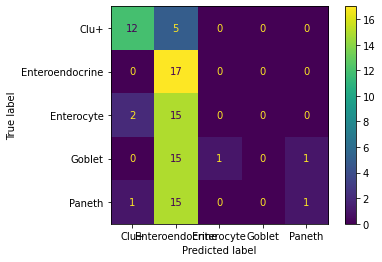

In [ ]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
cm = metrics.confusion_matrix(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred), labels=['2_CY3', '1_CY5', '2_YFP', '1_YFP',  '2_CY5'])
disp = ConfusionMatrixDisplay(cm, display_labels = ['Clu+', 'Enteroendocrine', 'Enterocyte', 'Goblet', 'Paneth'])
disp.plot()
plt.show()

In [ ]:
# make a visual confusion matrix
from skimage import io
true_label = '1_YFP'
true_type = 'goblet'
pred_label = '2_YFP'
pred_type = 'enterocyte'
output = pd.DataFrame(np.asarray([encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred)]).T, columns = ["True", "Pred"])
X_test_ids.reset_index(drop = True, inplace = True)
properties = pd.DataFrame()
for i in range(len(output)):
  # if the true and pred match that particular quadrant
  if output.loc[i, "True"] == true_label and output.loc[i, "Pred"] == pred_label:
    # get the id/block/sample
    # match sampled on Rd1_orig_label_DAPI, block, and sample
    id = X_test_ids.loc[i, "Rd1_orig_label_DAPI"]
    block = X_test_ids.loc[i, "block"]
    sample = X_test_ids.loc[i, "sample"]
    cell_of_interest = sampled[(sampled["Rd1_orig_label_DAPI"] == id) & (sampled["block"] == block) & (sampled["sample"] == sample)]
    # load the image
    image = io.imread('/content/drive/MyDrive/FateTrack_Main/test/1028/' + sample + '_2trailing_block' + str(block) + 'of9/hcr/rd1/raw/1.tif')
    # get the centroids and expand
    x_range = (max(0, cell_of_interest.loc[cell_of_interest.index[0], 'nuc_Rd1_centroid-1'] - 25), min(image.shape[1], cell_of_interest.loc[cell_of_interest.index[0], 'nuc_Rd1_centroid-1'] + 25))
    y_range = (max(0, cell_of_interest.loc[cell_of_interest.index[0], 'nuc_Rd1_centroid-0'] - 25), min(image.shape[0], cell_of_interest.loc[cell_of_interest.index[0], 'nuc_Rd1_centroid-0'] + 25))
    # get the mCherry image in the bounding box
    # save to classifier_verification/true_type/pred_type/
    io.imsave('/content/drive/MyDrive/FateTrack_Main/test/classifier_verification/1114/' + true_type + '/' + pred_type + '/' + sample + '_' + str(block) + '_' + str(id) + '.tif', image[int(y_range[0]):int(y_range[1]), int(x_range[0]):int(x_range[1])])
    properties = pd.concat([properties, cell_of_interest[["Rd1_orig_label_DAPI", "area", "filled_area", "bbox_area", "eccentricity", "solidity", "convex_area",
            "orientation", "major_axis_length","minor_axis_length", "euler_number", "perimeter", "extent",
            "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]]], axis = 0)
properties.to_csv('/content/drive/MyDrive/FateTrack_Main/test/classifier_verification/1114/' + true_type + '/' + pred_type + '/properties.csv')

In [ ]:
from sklearn.metrics import accuracy_score


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred, average=None)
# '1_YFP', '2_CY3', '2_CY5', '2_YFP'
# Goblet, Clu+, Paneth, Enterocyte

0.7009803921568628

In [ ]:
X_full = X[["area", "filled_area", "bbox_area", "eccentricity", "solidity", "convex_area",
            "orientation", "major_axis_length","minor_axis_length", "euler_number", "perimeter", "extent",
            "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells",
            'phase_moments_central-0-0', 'phase_moments_central-0-1',
            'phase_moments_central-0-2', 'phase_moments_central-0-3',
            'phase_moments_central-1-0', 'phase_moments_central-1-1',
            'phase_moments_central-1-2', 'phase_moments_central-1-3',
            'phase_moments_central-2-0', 'phase_moments_central-2-1',
            'phase_moments_central-2-2', 'phase_moments_central-2-3',
            'phase_moments_central-3-0', 'phase_moments_central-3-1',
            'phase_moments_central-3-2', 'phase_moments_central-3-3']]
scaler = StandardScaler()
X_full = scaler.fit_transform(X_full)

In [ ]:
cv_scores = cross_validate(model, X_full, np.ravel(y), scoring = 'roc_auc', cv = 10)
sum(cv_scores['test_score']) / 10

0.7584666955017301

In [ ]:
# get average f1 score for each pairwise comparison

# features for training
features = ["area", "filled_area", "bbox_area", "eccentricity", "solidity", "convex_area",
        "orientation", "major_axis_length","minor_axis_length", "euler_number", "perimeter", "extent",
        "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells",
        'phase_moments_central-0-0', 'phase_moments_central-0-1',
        'phase_moments_central-0-2', 'phase_moments_central-0-3',
        'phase_moments_central-1-0', 'phase_moments_central-1-1',
        'phase_moments_central-1-2', 'phase_moments_central-1-3',
        'phase_moments_central-2-0', 'phase_moments_central-2-1',
        'phase_moments_central-2-2', 'phase_moments_central-2-3',
        'phase_moments_central-3-0', 'phase_moments_central-3-1',
        'phase_moments_central-3-2', 'phase_moments_central-3-3']

for i, channel1 in enumerate(['1_CY5', '1_YFP', '2_CY3', '2_CY5', '2_YFP', '1_YFP_2_CY5']):
  for channel2 in ['1_CY5', '1_YFP', '2_CY3', '2_CY5', '2_YFP', '1_YFP_2_CY5'][i+1: ]:
    # get the data and format
    X = sample_celltypes_gobpan(final_df, [channel1, channel2])
    y = []
    for type_list in X['celltype']:
      if len(type_list) == 2 :
        y.append('1_YFP_2_CY5')
      else:
        y.append(type_list[0])
    encoder = LabelBinarizer()
    y = encoder.fit_transform(y)

    # train-test split
    scaler = StandardScaler()
    X = scaler.fit_transform(X[features])

    model = RandomForestClassifier(n_estimators = 500)

    cv_scores = cross_validate(model, X, np.ravel(y), scoring = 'accuracy', cv = 5)
    print(channel1 + " vs " + channel2)
    print(sum(cv_scores['test_score']) / 5)

1_CY5 vs 1_YFP
0.5388511985526911
1_CY5 vs 2_CY3
0.9
1_CY5 vs 2_CY5
0.6294117647058823
1_CY5 vs 2_YFP
0.6815789473684211
1_CY5 vs 1_YFP_2_CY5
0.5698850574712644
1_YFP vs 2_CY3
0.8253731343283583
1_YFP vs 2_CY5
0.5176470588235293
1_YFP vs 2_YFP
0.6655359565807326
1_YFP vs 1_YFP_2_CY5
0.5351724137931034
2_CY3 vs 2_CY5
0.7529411764705882
2_CY3 vs 2_YFP
0.7796116504854369
2_CY3 vs 1_YFP_2_CY5
0.6836781609195401
2_CY5 vs 2_YFP
0.5588235294117647
2_CY5 vs 1_YFP_2_CY5
0.5004597701149425
2_YFP vs 1_YFP_2_CY5
0.5482758620689655


In [ ]:
len(np.ravel(y))

584

In [ ]:
all_perm_imp = pd.DataFrame()

# get average f1 score for each pairwise comparison

# features for training
features = ["area", "filled_area", "bbox_area", "eccentricity", "solidity", "convex_area",
        "orientation", "major_axis_length","minor_axis_length", "euler_number", "perimeter", "extent",
        "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells",
        'phase_moments_central-0-0', 'phase_moments_central-0-1',
        'phase_moments_central-0-2', 'phase_moments_central-0-3',
        'phase_moments_central-1-0', 'phase_moments_central-1-1',
        'phase_moments_central-1-2', 'phase_moments_central-1-3',
        'phase_moments_central-2-0', 'phase_moments_central-2-1',
        'phase_moments_central-2-2', 'phase_moments_central-2-3',
        'phase_moments_central-3-0', 'phase_moments_central-3-1',
        'phase_moments_central-3-2', 'phase_moments_central-3-3']

for i, channel1 in enumerate(['1_CY5', '1_YFP', '2_CY3', '2_CY5', '2_YFP', '1_YFP_2_CY5']):
  for channel2 in ['1_CY5', '1_YFP', '2_CY3', '2_CY5', '2_YFP', '1_YFP_2_CY5'][i+1: ]:
    # get the data and format
    X = sample_celltypes_gobpan(final_df, [channel1, channel2])
    y = []
    for type_list in X['celltype']:
      if len(type_list) == 2 :
        y.append('1_YFP_2_CY5')
      else:
        y.append(type_list[0])
    encoder = LabelBinarizer()
    y = encoder.fit_transform(y)

    # train-test split
    scaler = StandardScaler()
    X = scaler.fit_transform(X[features])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 2, stratify = y)

    model = RandomForestClassifier(n_estimators = 500)
    model.fit(X_train, np.ravel(y_train))

    perm_imp = permutation_importance(model, X_test, y_test)
    perm_imp = pd.DataFrame(perm_imp.importances_mean)
    all_perm_imp = pd.concat([all_perm_imp, perm_imp], axis = 1)

In [ ]:
all_perm_imp.to_csv('/content/drive/MyDrive/FateTrack_Main/test/classifier_verification/perm_imp_5.csv')

In [ ]:
print(sum(auc) / len(auc))
print(all_perm_imp.mean(axis = 1))

0.6540441176470587
0     0.009091
1    -0.001818
2     0.047879
3     0.006667
4     0.005455
5     0.001212
6    -0.001818
7     0.001212
8    -0.003030
9    -0.023636
10   -0.004242
11   -0.001212
12   -0.001212
13    0.005455
14    0.004242
15    0.006667
16    0.006061
17    0.006061
18   -0.003636
19   -0.001212
20   -0.002424
21   -0.015758
22    0.003636
23    0.007879
24   -0.011515
25    0.003636
26   -0.002424
27   -0.000606
28    0.003030
29   -0.015152
30    0.010909
dtype: float64


In [ ]:
from sklearn.svm import SVC
svm_model = SVC(gamma = 'auto', kernel = 'poly', degree = 3)
svm_model.fit(X_train, np.ravel(y_train))
y_pred = svm_model.predict(X_test)


In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/FateTrack_Main/test/1028/test_df.csv')

In [ ]:
for cell in test_data:
  # match on Rd1_orig_label_DAPI, block, and sample
  # get the bounding box
  # get the mCherry image in the bounding box
  # save to test_images/true_type/pred_type/

In [ ]:
# morphology quantitative comparison
# get EE cells
ee_rows = []
for i in final_df.index:
  if '1_CY5' in final_df.loc[i, 'celltype']:
    ee_rows.append(i)
ee_cells = final_df.iloc[ee_rows, :]

# Find feature distributions for the known cell types

In [ ]:
# initialize figure with 6 rows (1 for each celltype), 15 columns (1 for each feature)
fig_hist, axs_hist = plt.subplots(6, 15, figsize=(30, 15))
# fig_box, axs_box = plt.subplots(1, 15, figsize=(30, 5))
for n_feat, feature in enumerate(["area", "bbox_area", "eccentricity", "solidity", "convex_area",
            "orientation", "major_axis_length","minor_axis_length", "perimeter", "extent",
            "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]): # for each feature
  # plt.figure(1)
  feature_df = pd.DataFrame()
  min_feat = min(final_df[feature])
  max_feat = max(final_df[feature])
  for n_channel, channel in enumerate(['1_CY5', '2_CY3', '2_YFP', '1_YFP', '2_CY5']): # for each cell type
    feature_vector = []
    for i in range(len(final_df)):
      if channel in final_df.loc[i, 'celltype']:
        # add that feature to a vector
        feature_vector.append(final_df.loc[i, feature])
    # concatenate vector to existing dataframe vertically
    feature_df = pd.concat([feature_df, pd.DataFrame(feature_vector)], axis = 1)
    axs_hist[n_channel, n_feat].hist(feature_vector, range = (min_feat, max_feat))  # add histogram for the feature


  # same for paneth/goblet cells
  feature_vector = []
  for i in range(len(final_df)):
    if '1_YFP' in final_df.loc[i, 'celltype'] and '2_CY5' in final_df.loc[i, 'celltype']:
      # add that feature to a vector
      feature_vector.append(final_df.loc[i, feature])
  # concatenate vector to existingn dataframe vertically
  feature_df = pd.concat([feature_df, pd.DataFrame(feature_vector)], axis = 1)
  axs_hist[5, n_feat].hist(feature_vector, range = (min_feat, max_feat))  # add histogram for the feature
  axs_hist[5, n_feat].set_xlabel(xlabel = feature, fontsize = 10)

  # create multi-boxplot for the feature
  # plt.figure(2)
  # axs_box[n_feat].boxplot(feature_df)
for row, name in enumerate(['Enteroendocrine', 'Clu+', 'Enterocyte', 'Goblet', 'Paneth', 'Goblet/Paneth']):
  axs_hist[row, 0].set_ylabel(ylabel = name, fontsize = 10)

# plt.figure(1)
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.savefig("/content/drive/MyDrive/FateTrack_Main/test/1028/histograms.png", dpi = 100)
# plt.figure(2)
# plt.xticks(fontsize = 5)
# plt.yticks(fontsize = 5)
# plt.savefig("/content/drive/MyDrive/FateTrack_Main/test/1028/boxplots.png", dpi = 100)

In [ ]:
# initialize figure with 6 rows (1 for each celltype), 15 columns (1 for each feature)
fig_hist, axs_hist = plt.subplots(2, 15, figsize=(50, 10))
for n_feat, feature in enumerate(["area", "bbox_area", "eccentricity", "solidity", "convex_area",
            "orientation", "major_axis_length","minor_axis_length", "perimeter", "extent",
            "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]): # for each feature
  feature_df = pd.DataFrame()
  min_feat = min(sampled[feature])
  max_feat = max(sampled[feature])
  for n_channel, channel in enumerate(['2_YFP', '1_YFP']): # for each cell type
    feature_vector = []
    for i in range(len(sampled)):
      if channel in sampled.loc[i, 'celltype']:
        # add that feature to a vector
        feature_vector.append(sampled.loc[i, feature])
    # concatenate vector to existing dataframe vertically
    feature_df = pd.concat([feature_df, pd.DataFrame(feature_vector)], axis = 1)
    axs_hist[n_channel, n_feat].hist(feature_vector, range = (min_feat, max_feat))  # add histogram for the feature
    axs_hist[1, n_feat].set_xlabel(xlabel = feature, fontsize = 10)


for row, name in enumerate(['Enterocyte', 'Goblet']):
  axs_hist[row, 0].set_ylabel(ylabel = name, fontsize = 10)

plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.savefig("/content/drive/MyDrive/FateTrack_Main/test/1028/histograms_enterocyte_goblet.png", dpi = 100)

In [ ]:
import random

In [ ]:
# confusion matrix histograms
T_gob_P_gob = pd.DataFrame()
T_gob_P_ent = pd.DataFrame()
T_ent_P_gob = pd.DataFrame()
T_ent_P_ent = pd.DataFrame()

for i in range(10):
  df = final_df
  channels = ['1_YFP', '2_YFP']
  minCells = sys.maxsize
  celltypes = []
  for type_list in df['celltype']:
    celltypes.append(type_list[2:-2])
  celltypes
  for channel in channels:
      chanIDs = [celltype for celltype in celltypes if celltype == channel]
      if len(chanIDs) < minCells:
          minCells = len(chanIDs)
  sampled = pd.DataFrame()
  for channel in channels:
      chanIDs = [i for i in range(len(celltypes)) if celltypes[i] == channel]
      if len(chanIDs) > minCells:
          chanIDs = random.sample(chanIDs, minCells)
      sampled = pd.concat([sampled, df.iloc[chanIDs]], axis = 0)
  sampled.reset_index(inplace=True, drop=True)

  X = sampled
  y = []
  for type_list in sampled['celltype']:
    y.append(type_list[2:-2])
  encoder = LabelBinarizer()
  y = encoder.fit_transform(y)

  # train-test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = random.randint(0, 5000), stratify = y) # use stratify for classification
  X_train_ids = X_train[["Rd1_orig_label_DAPI", "block", "sample"]]
  X_train = X_train[["area", "filled_area", "bbox_area", "eccentricity", "solidity", "convex_area",
              "orientation", "major_axis_length","minor_axis_length", "euler_number", "perimeter", "extent",
              "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]]
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test_ids = X_test[["Rd1_orig_label_DAPI", "block", "sample"]]
  X_test = X_test[["area", "filled_area", "bbox_area", "eccentricity", "solidity", "convex_area",
              "orientation", "major_axis_length","minor_axis_length", "euler_number", "perimeter", "extent",
              "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]]
  X_test = scaler.transform(X_test)

  model = RandomForestClassifier(n_estimators = 500)
  model.fit(X_train, np.ravel(y_train))
  y_pred = model.predict(X_test)
  print(metrics.confusion_matrix(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred), labels=['1_YFP', '2_YFP']))



  output = pd.DataFrame(np.asarray([encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred)]).T, columns = ["True", "Pred"])
  for true_label in ['1_YFP', '2_YFP']:
    for pred_label in ['1_YFP', '2_YFP']:
      X_test_ids.reset_index(drop = True, inplace = True)
      properties = pd.DataFrame()
      for i in range(len(output)):
        # if the true and pred match that particular quadrant
        if output.loc[i, "True"] == true_label and output.loc[i, "Pred"] == pred_label:
          # get the id/block/sample
          # match sampled on Rd1_orig_label_DAPI, block, and sample
          id = X_test_ids.loc[i, "Rd1_orig_label_DAPI"]
          block = X_test_ids.loc[i, "block"]
          sample = X_test_ids.loc[i, "sample"]
          cell_of_interest = sampled[(sampled["Rd1_orig_label_DAPI"] == id) & (sampled["block"] == block) & (sampled["sample"] == sample)]
          if true_label == '1_YFP' and pred_label == '1_YFP':
            T_gob_P_gob = pd.concat([T_gob_P_gob, cell_of_interest[["area", "bbox_area", "eccentricity", "solidity", "convex_area",
                  "orientation", "major_axis_length","minor_axis_length", "perimeter", "extent",
                  "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]]], axis = 0)
          if true_label == '1_YFP' and pred_label == '2_YFP':
            T_gob_P_ent = pd.concat([T_gob_P_ent, cell_of_interest[["area", "bbox_area", "eccentricity", "solidity", "convex_area",
                  "orientation", "major_axis_length","minor_axis_length", "perimeter", "extent",
                  "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]]], axis = 0)
          if true_label == '2_YFP' and pred_label == '1_YFP':
            T_ent_P_gob = pd.concat([T_ent_P_gob, cell_of_interest[["area", "bbox_area", "eccentricity", "solidity", "convex_area",
                  "orientation", "major_axis_length","minor_axis_length", "perimeter", "extent",
                  "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]]], axis = 0)
          if true_label == '2_YFP' and pred_label == '2_YFP':
            T_ent_P_ent = pd.concat([T_ent_P_ent, cell_of_interest[["area", "bbox_area", "eccentricity", "solidity", "convex_area",
                  "orientation", "major_axis_length","minor_axis_length", "perimeter", "extent",
                  "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]]], axis = 0)

[[12  5]
 [ 3 13]]
[[13  4]
 [ 6 10]]
[[11  5]
 [ 3 14]]
[[12  5]
 [ 5 11]]
[[10  6]
 [ 3 14]]
[[ 7 10]
 [ 6 10]]
[[ 9  8]
 [ 5 11]]
[[13  4]
 [ 4 12]]
[[12  5]
 [ 5 11]]
[[11  6]
 [ 2 14]]


In [ ]:
T_gob_P_gob.drop_duplicates(inplace=True)
T_gob_P_ent.drop_duplicates(inplace=True)
T_ent_P_gob.drop_duplicates(inplace=True)
T_ent_P_ent.drop_duplicates(inplace=True)

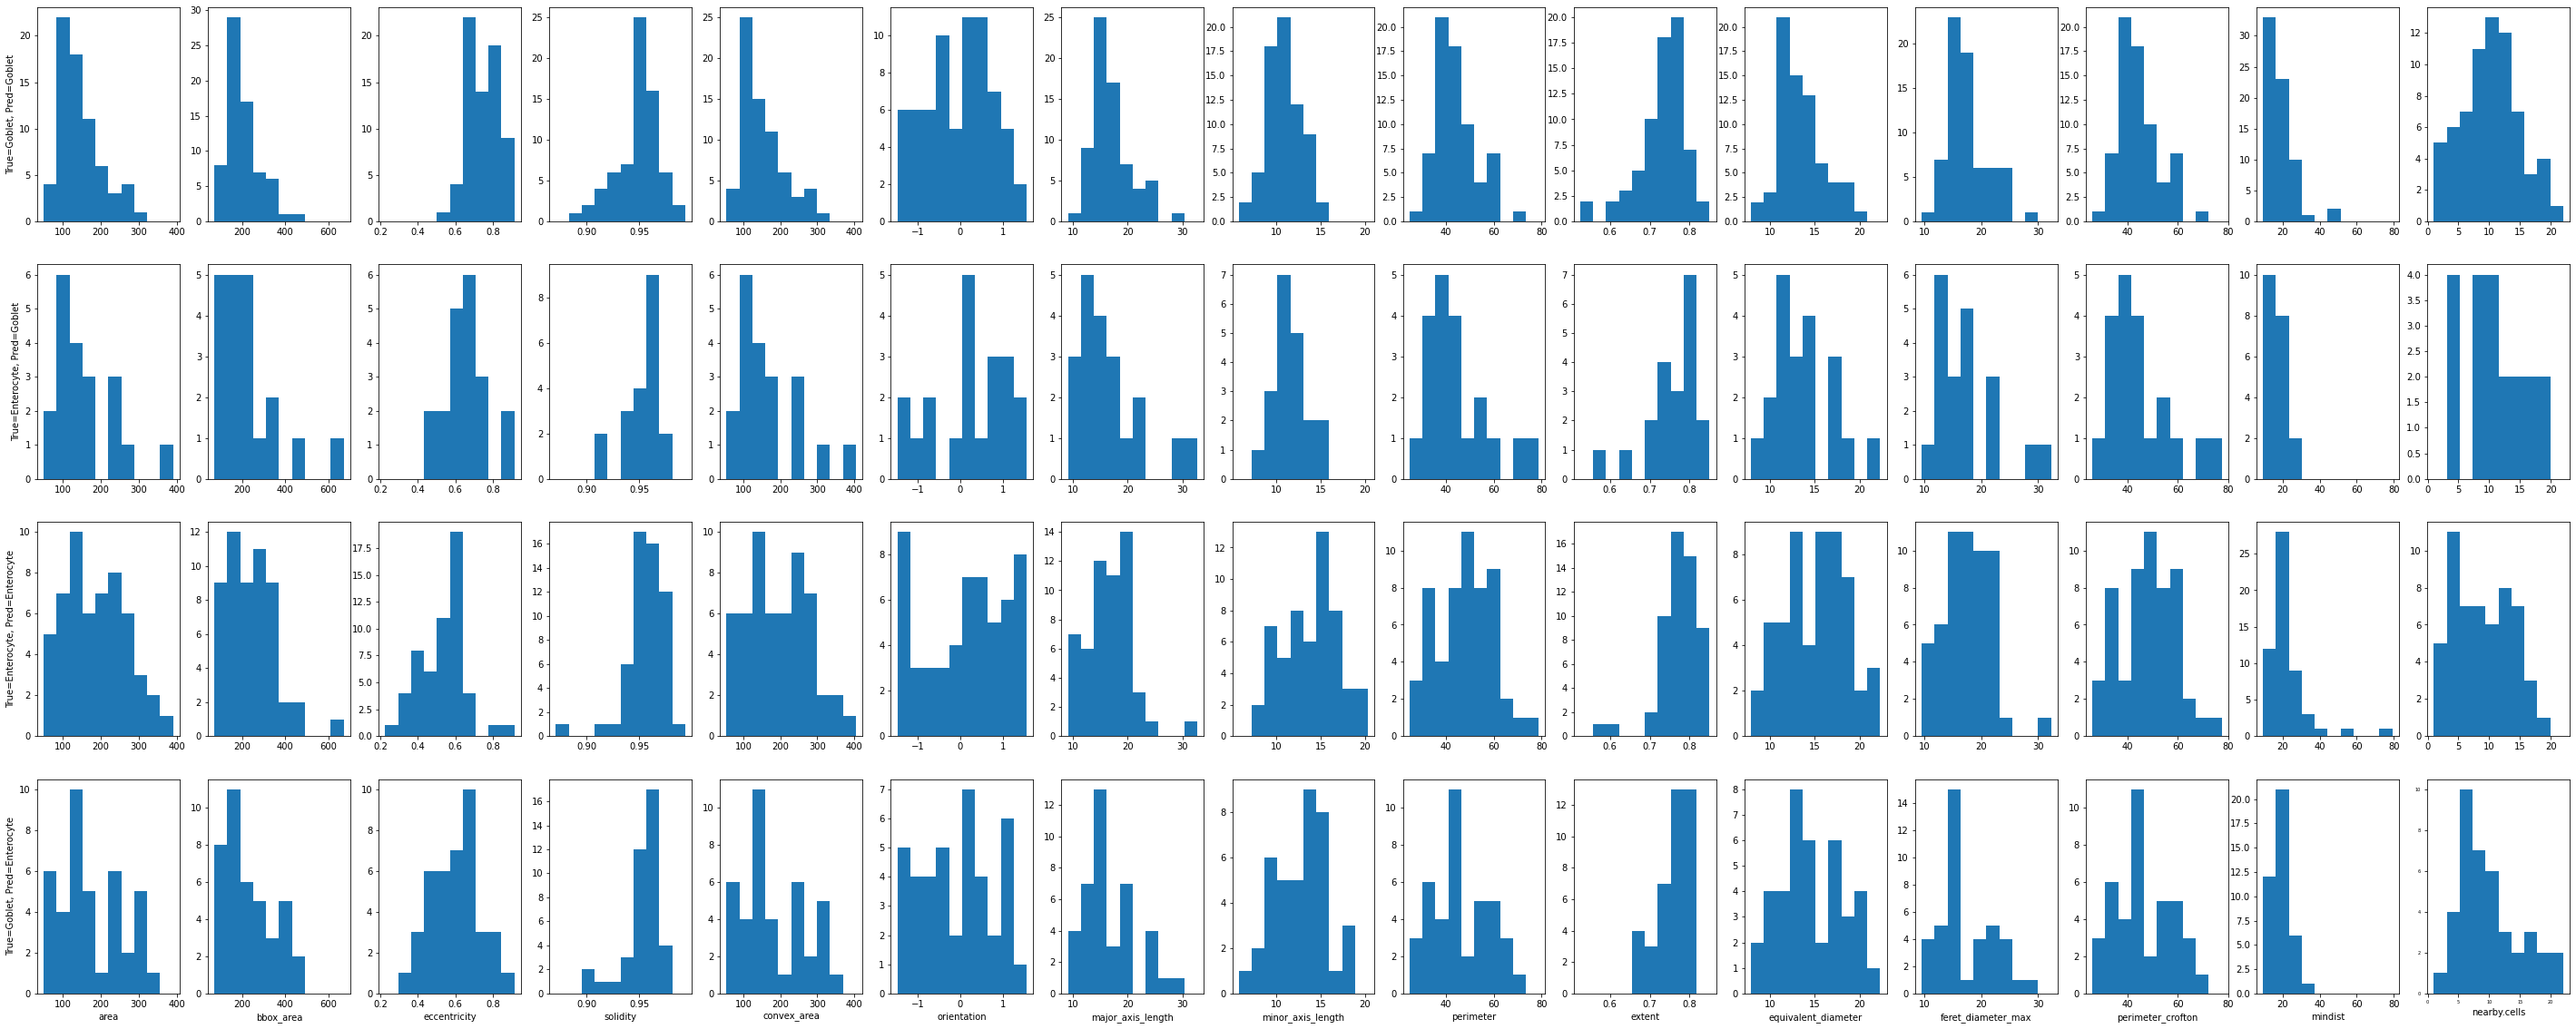

In [ ]:
full_df = pd.concat([T_gob_P_gob, T_gob_P_ent, T_ent_P_gob, T_ent_P_ent], axis = 0)


fig_hist, axs_hist = plt.subplots(4, 15, figsize=(50, 20))
for n_feat, feature in enumerate(["area", "bbox_area", "eccentricity", "solidity", "convex_area",
            "orientation", "major_axis_length","minor_axis_length", "perimeter", "extent",
            "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]): # for each feature
  feature_df = pd.DataFrame()
  min_feat = min(full_df[feature])
  max_feat = max(full_df[feature])
  for i, results_df in enumerate([T_gob_P_gob, T_ent_P_gob, T_ent_P_ent, T_gob_P_ent]):
    axs_hist[i, n_feat].hist(results_df[feature], range = (min_feat, max_feat))  # add histogram for the feature
    axs_hist[3, n_feat].set_xlabel(xlabel = feature, fontsize = 10)


for row, name in enumerate(['True=Goblet, Pred=Goblet', 'True=Enterocyte, Pred=Goblet', 'True=Enterocyte, Pred=Enterocyte', 'True=Goblet, Pred=Enterocyte']):
  axs_hist[row, 0].set_ylabel(ylabel = name, fontsize = 10)

plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.savefig("/content/drive/MyDrive/FateTrack_Main/test/1028/histograms_confusion_matrix.png", dpi = 100)

In [ ]:
print(len(T_gob_P_gob))
print(len(T_gob_P_ent))
print(len(T_ent_P_gob))
print(len(T_ent_P_ent))


69
40
20
55


In [ ]:
upper = pd.concat([T_gob_P_gob, T_gob_P_ent], axis = 0)
print(len(upper) - len(upper.drop_duplicates(ignore_index=True)))
left = pd.concat([T_gob_P_gob, T_ent_P_gob], axis = 0)
print(len(left) - len(left.drop_duplicates(ignore_index=True)))
right = pd.concat([T_ent_P_ent, T_gob_P_ent], axis = 0)
print(len(right) - len(right.drop_duplicates(ignore_index=True)))
lower = pd.concat([T_ent_P_ent, T_gob_P_ent], axis = 0)
print(len(lower) - len(lower.drop_duplicates(ignore_index=True)))

10
0
0
0


In [ ]:
final_df

# PCA

In [ ]:
# replace the list format for celltypes
for i, celltype in enumerate(final_df['celltype']):
  final_df.loc[i, 'celltype'] = celltype[0]

In [ ]:
data_df = final_df[final_df['celltype'].isin(['1_YFP', '2_YFP'])]
features = data_df[["area", "bbox_area", "eccentricity", "solidity", "convex_area",
                  "orientation", "major_axis_length","minor_axis_length", "perimeter", "extent",
                  "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]]

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
model = PCA()
pca_res = model.fit_transform(features)

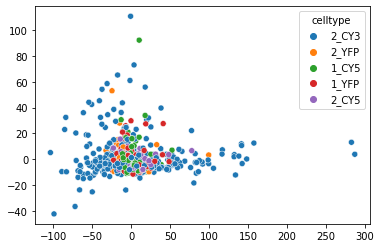

In [ ]:
import seaborn as sns
sns.scatterplot(x=pca_res[:,1], y=pca_res[:,2], hue=data_df['celltype'])

plt.show()

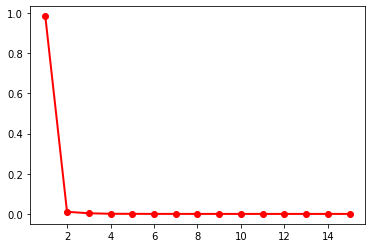

In [ ]:
PC_values = np.arange(model.n_components_) + 1
plt.plot(PC_values, model.explained_variance_ratio_, 'ro-', linewidth=2)

In [ ]:
model.explained_variance_ratio_

array([9.94840985e-01, 4.18286044e-03, 5.28936064e-04, 3.35051915e-04,
       4.78844103e-05, 4.04842826e-05, 2.01290047e-05, 2.70838220e-06,
       4.27758951e-07, 4.03437461e-07, 7.91304719e-08, 3.23467276e-08,
       1.37987829e-08, 3.28849875e-09, 2.53616368e-10])

# Visual Confusion Matrix

In [ ]:
# make a visual confusion matrix
used_ids = []
from skimage import io
from sklearn import metrics
for i in range(10):
  sampled = sample_celltypes(final_df, ['1_YFP', '2_YFP'])
  X = sampled
  y = []
  for type_list in sampled['celltype']:
    y.append(type_list[0])
  encoder = LabelBinarizer()
  y = encoder.fit_transform(y)

  # train-test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = random.randint(0, 1000), stratify = y) # use stratify for classification
  X_train_ids = X_train[["Rd1_orig_label_DAPI", "block", "sample"]]
  X_train = X_train[["area", "bbox_area", "eccentricity", "solidity", "convex_area",
              "orientation", "major_axis_length","minor_axis_length", "perimeter", "extent",
              "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]]
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test_ids = X_test[["Rd1_orig_label_DAPI", "block", "sample"]]
  X_test = X_test[["area", "bbox_area", "eccentricity", "solidity", "convex_area",
              "orientation", "major_axis_length","minor_axis_length", "perimeter", "extent",
              "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]]
  X_test = scaler.transform(X_test)

  model = RandomForestClassifier(n_estimators = 500)
  model.fit(X_train, np.ravel(y_train))
  y_pred = model.predict(X_test)
  print(metrics.confusion_matrix(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred), labels=['1_YFP', '2_YFP']))
  output = pd.DataFrame(np.asarray([encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred)]).T, columns = ["True", "Pred"])
  X_test_ids.reset_index(drop = True, inplace = True)

  for true_label, true_type in [('1_YFP', 'goblet'), ('2_YFP', 'enterocyte')]:
    for pred_label, pred_type in [('1_YFP', 'goblet'), ('2_YFP', 'enterocyte')]:
      for i in range(len(output)):
        # if the true and pred match that particular quadrant
        if output.loc[i, "True"] == true_label and output.loc[i, "Pred"] == pred_label:
          # get the id/block/sample
          # match sampled on Rd1_orig_label_DAPI, block, and sample
          id = X_test_ids.loc[i, "Rd1_orig_label_DAPI"]
          if id in used_ids:
            continue
          else:
            used_ids.append(id)
          block = X_test_ids.loc[i, "block"]
          sample = X_test_ids.loc[i, "sample"]
          cell_of_interest = sampled[(sampled["Rd1_orig_label_DAPI"] == id) & (sampled["block"] == block) & (sampled["sample"] == sample)]
          # load the image
          image = io.imread('/content/drive/MyDrive/FateTrack_Main/test/1028/' + sample + '_2trailing_block' + str(block) + 'of9/timelapse/nuc/1.tif')
          # get the centroids and expand
          x_range = (max(0, cell_of_interest.loc[cell_of_interest.index[0], 'bbox-1'] - 10), min(image.shape[1], cell_of_interest.loc[cell_of_interest.index[0], 'bbox-3'] + 10))
          y_range = (max(0, cell_of_interest.loc[cell_of_interest.index[0], 'bbox-0'] - 10), min(image.shape[0], cell_of_interest.loc[cell_of_interest.index[0], 'bbox-2'] + 10))
          # get the mCherry image in the bounding box
          # save to classifier_verification/true_type/pred_type/
          io.imsave('/content/drive/MyDrive/FateTrack_Main/test/classifier_verification/1123_a/' + true_type + '/' + pred_type + '/' + sample + '_' + str(block) + '_' + str(id) + '.jpg', image[int(y_range[0]):int(y_range[1]), int(x_range[0]):int(x_range[1])])
      #     properties = pd.concat([properties, cell_of_interest[["Rd1_orig_label_DAPI", "area", "filled_area", "bbox_area", "eccentricity", "solidity", "convex_area",
      #             "orientation", "major_axis_length","minor_axis_length", "euler_number", "perimeter", "extent",
      #             "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]]], axis = 0)
      # properties.to_csv('/content/drive/MyDrive/FateTrack_Main/test/classifier_verification/1114/' + true_type + '/' + pred_type + '/properties.csv')

In [ ]:
# make a visual confusion matrix - multiple types, and get information about
def make_visual_confusion_matrix(final_df, type1, type2, size):
  channel1, name1 = type1
  channel2, name2 = type2

  t1_p1_ids = []
  t1_p2_ids = []
  t2_p1_ids = []
  t2_p2_ids = []
  ids = [t1_p1_ids, t1_p2_ids, t2_p1_ids, t2_p2_ids]
  confusion_matrices = []
  roc_auc = []

  mcherry = [{'507_D3_1_w1':np.zeros(shape=(size * 10, size * 10)), '507_D3_1_w2':np.zeros(shape=(size * 10, size * 10))} for i in range(4)]
  brightfield = [{'507_D3_1_w1':np.zeros(shape=(size * 10, size * 10)), '507_D3_1_w2':np.zeros(shape=(size * 10, size * 10))} for i in range(4)]
  mcherry_seg = [{'507_D3_1_w1':np.zeros(shape=(size * 10, size * 10, 3)), '507_D3_1_w2':np.zeros(shape=(size * 10, size * 10, 3))} for i in range(4)]
  brightfield_seg = [{'507_D3_1_w1':np.zeros(shape=(size * 10, size * 10)), '507_D3_1_w2':np.zeros(shape=(size * 10, size * 10))} for i in range(4)]
  brightfield_seg_exp = [{'507_D3_1_w1':np.zeros(shape=((size + 20) * 10, (size + 20) * 10)), '507_D3_1_w2':np.zeros(shape=((size + 20) * 10, (size + 20) * 10))} for i in range(4)]
  well_counts = [{'507_D3_1_w1':0, '507_D3_1_w2':0} for i in range(4)]
  # brightfield_seg_min = [{'507_D3_1_w1':60000, '507_D3_1_w2':60000} for i in range(4)]

  for i in range(10):
    sampled = sample_celltypes_gobpan(final_df, [channel1, channel2])
    X = sampled
    y = []
    for type_list in sampled['celltype']:
      if len(type_list) == 2:
        y.append("1_YFP_2_CY5")
      else:
        y.append(type_list[0])
    encoder = LabelBinarizer()
    y = encoder.fit_transform(y)

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = random.randint(0, 1000), stratify = y) # use stratify for classification
    X_train_ids = X_train[["Rd1_orig_label_DAPI", "block", "sample"]]
    X_train = X_train[["area", "bbox_area", "eccentricity", "solidity", "convex_area",
                "orientation", "major_axis_length","minor_axis_length", "perimeter", "extent",
                "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test_ids = X_test[["Rd1_orig_label_DAPI", "block", "sample"]]
    X_test = X_test[["area", "bbox_area", "eccentricity", "solidity", "convex_area",
                "orientation", "major_axis_length","minor_axis_length", "perimeter", "extent",
                "equivalent_diameter", "feret_diameter_max", "perimeter_crofton", "mindist", "nearby.cells"]]
    X_test = scaler.transform(X_test)

    model = RandomForestClassifier(n_estimators = 500)
    model.fit(X_train, np.ravel(y_train))
    y_pred = model.predict(X_test)
    confusion_matrices.append(metrics.confusion_matrix(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred), labels=[channel1, channel2]))
    roc_auc.append(metrics.roc_auc_score(y_test, y_pred, average=None))
    output = pd.DataFrame(np.asarray([encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred)]).T, columns = ["True", "Pred"])
    X_test_ids.reset_index(drop = True, inplace = True)

    j = 0
    for true_label, true_type in [(channel1, name1), (channel2, name2)]:
      for pred_label, pred_type in [(channel1, name1), (channel2, name2)]:
        for i in range(len(output)):
          # if the true and pred match that particular quadrant
          if output.loc[i, "True"] == true_label and output.loc[i, "Pred"] == pred_label:
            # get the id/block/sample
            # match sampled on Rd1_orig_label_DAPI, block, and sample
            id = X_test_ids.loc[i, "Rd1_orig_label_DAPI"]
            block = X_test_ids.loc[i, "block"]
            sample = X_test_ids.loc[i, "sample"]
            if (id, block, sample) in ids[j]: # TODO: CHANGE THIS TO REFLECT THE CONDITION -- search for doubles at the end
              continue
            else:
              ids[j].append((id, block, sample))

            cell_of_interest = sampled[(sampled["Rd1_orig_label_DAPI"] == id) & (sampled["block"] == block) & (sampled["sample"] == sample)]
            # load the image
            image = mcherry_images[sample][block]
            # get the centroids and expand
            x_range = (max(0, cell_of_interest.loc[cell_of_interest.index[0], 'bbox-1']), min(image.shape[1], cell_of_interest.loc[cell_of_interest.index[0], 'bbox-3']))
            y_range = (max(0, cell_of_interest.loc[cell_of_interest.index[0], 'bbox-0']), min(image.shape[0], cell_of_interest.loc[cell_of_interest.index[0], 'bbox-2']))
            x_range_exp = (max(0, cell_of_interest.loc[cell_of_interest.index[0], 'bbox-1'] - 10), min(image.shape[1], cell_of_interest.loc[cell_of_interest.index[0], 'bbox-3'] + 10))
            y_range_exp = (max(0, cell_of_interest.loc[cell_of_interest.index[0], 'bbox-0'] - 10), min(image.shape[0], cell_of_interest.loc[cell_of_interest.index[0], 'bbox-2'] + 10))

            # get the mCherry image in the bounding box
            image_bbox = image[int(y_range[0]):int(y_range[1]), int(x_range[0]):int(x_range[1])]
            brightfield_bbox = bf_images[sample][block][int(y_range[0]):int(y_range[1]), int(x_range[0]):int(x_range[1])]
            mcherry_outline_bbox = mcherry_outlines[sample][block][int(y_range[0]):int(y_range[1]), int(x_range[0]):int(x_range[1]), :]
            brightfield_outline_bbox = bf_outlines[sample][block][int(y_range[0]):int(y_range[1]), int(x_range[0]):int(x_range[1])]
            brightfield_outline_bbox_exp = bf_outlines[sample][block][int(y_range_exp[0]):int(y_range_exp[1]), int(x_range_exp[0]):int(x_range_exp[1])]

            # embed in correct larger image
            # save_dir = '/content/drive/MyDrive/FateTrack_Main/test/classifier_verification/1206/' + name1 + '_' + name2 + '/' + true_type + '/' + pred_type + '/'
            # try:
            w_count = well_counts[j][sample]
            if w_count >= 100:
              continue
            mcherry[j][sample][(w_count // 10 * size) : (w_count // 10 * size) + image_bbox.shape[0], (w_count % 10 * size) : (w_count % 10 * size) + image_bbox.shape[1]] = image_bbox
            brightfield[j][sample][(w_count // 10 * size) : (w_count // 10 * size) + image_bbox.shape[0], (w_count % 10 * size) : (w_count % 10 * size) + image_bbox.shape[1]] = brightfield_bbox
            mcherry_seg[j][sample][(w_count // 10 * size) : (w_count // 10 * size) + image_bbox.shape[0], (w_count % 10 * size) : (w_count % 10 * size) + image_bbox.shape[1], :] = mcherry_outline_bbox
            brightfield_seg[j][sample][(w_count // 10 * size) : (w_count // 10 * size) + image_bbox.shape[0], (w_count % 10 * size) : (w_count % 10 * size) + image_bbox.shape[1]] = brightfield_outline_bbox
            brightfield_seg_exp[j][sample][(w_count // 10 * (size + 20)) : (w_count // 10 * (size + 20)) + brightfield_outline_bbox_exp.shape[0], (w_count % 10 * (size + 20)) : (w_count % 10 * (size + 20)) + brightfield_outline_bbox_exp.shape[1]] = brightfield_outline_bbox_exp
            well_counts[j][sample] += 1
            # brightfield_seg_min[j][sample] = min(brightfield_seg_min[j][sample], np.min(brightfield_bbox))
        j += 1
  # save to classifier_verification/true_type/pred_type/
  j = 0
  for true_type in [name1, name2]:
    for pred_type in [name1, name2]:
      save_dir = '/content/drive/MyDrive/FateTrack_Main/test/classifier_verification/1207/' + name1 + '_' + name2 + '/' + true_type + '/' + pred_type + '/'
      if not os.path.exists(save_dir):
        os.makedirs(save_dir)
      for sample in ['507_D3_1_w1', '507_D3_1_w2']:
        # brightfield_seg[j][sample] = np.where(brightfield_seg[j][sample] == 0, np.ones(brightfield_seg[j][sample].shape) * brightfield_seg_min[j][sample], brightfield_seg[j][sample])
        io.imsave(save_dir + sample + '_mcherry.png', mcherry[j][sample])
        io.imsave(save_dir + sample + '_brightfield.png', brightfield[j][sample])
        io.imsave(save_dir + sample + '_mcherry_seg.png', mcherry_seg[j][sample])
        io.imsave(save_dir + sample + '_brightfield_seg.png', brightfield_seg[j][sample])
        io.imsave(save_dir + sample + '_brightfield_seg_exp.png', brightfield_seg_exp[j][sample])
      j += 1

  # perm_imp = permutation_importance(model, X_test, y_test)
  # perm_imp = pd.DataFrame(perm_imp.importances_mean)
  # return confusion_matrices, roc_auc, perm_imp, ids

In [ ]:
# load all the images so we don't have to do it thousands of times
mcherry_images = {'507_D3_1_w1':[], '507_D3_1_w2':[]}
bf_images = {'507_D3_1_w1':[], '507_D3_1_w2':[]}
mcherry_outlines = {'507_D3_1_w1':[], '507_D3_1_w2':[]}
bf_outlines = {'507_D3_1_w1':[], '507_D3_1_w2':[]}
for sample in ['507_D3_1_w1', '507_D3_1_w2']:
  for block in range(9):
    mcherry_image = io.imread('/content/drive/MyDrive/FateTrack_Main/test/1028/' + sample + '_2trailing_block' + str(block) + 'of9/timelapse/nuc/1.tif')
    bf_image = io.imread('/content/drive/MyDrive/FateTrack_Main/test/1028/' + sample + '_2trailing_block' + str(block) + 'of9/timelapse/bf/1.tif')
    mcherry_images[sample].append(mcherry_image)
    bf_images[sample].append(bf_image)
    # assemble image with outlines on top of actual image
    mask = io.imread('/content/drive/MyDrive/FateTrack_Main/test/1028/' + sample + '_2trailing_block' + str(block) + 'of9/timelapse/masks/1.tif')
    outlines = utils.masks_to_outlines(mask).astype('uint8')
    # mcherry outlines
    mcherry_image_color = mcherry_image.astype('uint8')
    color_img = color.gray2rgb(mcherry_image)
    color_img = (255*(color_img)/(np.max(color_img))).astype('uint8')
    red = np.where(outlines, np.ones(outlines.shape) * 255, color_img[:,:,0])
    green = np.where(outlines, np.zeros(outlines.shape), color_img[:,:,1])
    blue = np.where(outlines, np.zeros(outlines.shape), color_img[:,:,2])
    full_image = np.stack([red, green, blue], axis=2)
    # io.imsave('/content/drive/MyDrive/FateTrack_Main/test/mc_tmp.png', full_image)
    # mc_reload_img = io.imread('/content/drive/MyDrive/FateTrack_Main/test/mc_tmp.png')
    mcherry_outlines[sample].append(full_image)
    # brightfield outlines
    #cor_img = exposure.adjust_log(bf_image)
    cor_img = np.where(outlines, np.ones(outlines.shape) * np.min(bf_image), bf_image)
    io.imsave('/content/drive/MyDrive/FateTrack_Main/test/bf_tmp.png', cor_img)
    bf_reload_img = io.imread('/content/drive/MyDrive/FateTrack_Main/test/bf_tmp.png')
    bf_outlines[sample].append(bf_reload_img)




In [ ]:
outputs = []
type_list = ['1_CY5', '1_YFP', '2_CY5', '2_YFP', '1_YFP_2_CY5']
type_names = ['enteroendocrine', 'goblet', 'paneth', 'enterocyte', 'gobpan']
for i, type1 in enumerate(type_list):
  for j, type2 in enumerate(type_list[i+1:]):
    print(type_names[i] + ' vs ' + type_names[j+i+1])
    outputs.append(make_visual_confusion_matrix(final_df, (type1, type_names[i]), (type2, type_names[j + i + 1]), 35))
for j, type2 in enumerate(type_list):
    print('clu vs ' + type_names[j])
    outputs.append(make_visual_confusion_matrix(final_df, ('2_CY3', 'clu'), (type2, type_names[j]), 50))


In [ ]:
brightfield_seg_min[j][sample]

NameError: ignored

In [ ]:
# 1. make the images - done
# 2. analyze the confusion matrices & ROC for each - done
# 3. analyze the top features for each
# 4. analyze repeated cells across categories
# 5. make confusion matrices and color by sample

In [ ]:
with open('/content/drive/MyDrive/FateTrack_Main/test/classifier_verification/1206/outputs.pkl', 'wb') as output:
  dill.dump(outputs, output)

In [ ]:
outputs = load_object('/content/drive/MyDrive/FateTrack_Main/test/classifier_verification/1205/outputs.pkl')

In [ ]:
outputs[0][1]

[0.5208333333333334,
 0.5416666666666666,
 0.45833333333333337,
 0.4791666666666666,
 0.47916666666666663,
 0.3541666666666667,
 0.5416666666666667,
 0.45833333333333337,
 0.7083333333333334,
 0.4375]

In [ ]:
all_importances = pd.DataFrame()
for i in range(len(outputs)):
  all_importances = pd.concat([all_importances, outputs[i][2]], axis = 1)
all_importances.to_csv('/content/drive/MyDrive/FateTrack_Main/test/classifier_verification/1206/permutation_importances.csv')

In [ ]:
type_list = ['1_CY5', '1_YFP', '2_CY3', '2_CY5', '2_YFP', '1_YFP_2_CY5']
type_names = ['enteroendocrine', 'goblet', 'clu', 'paneth', 'enterocyte', 'gobpan']
k = 0
for i, type1 in enumerate(type_list):
  for j, type2 in enumerate(type_list[i+1:]):
    print(type_names[i] + ' vs ' + type_names[j+i+1])

    # get average confusion matrix
    print("average confusion matrix")
    for r,c in [(0,0), (0,1), (1,0), (1,1)]:
      all_vals = [outputs[k][0][round][r][c] for round in range(10)]
      print(sum(all_vals) / 10)

    # get average ROC AUC
    print("average ROC AUC")
    print(sum(outputs[k][1]) / 10)

    k += 1

In [ ]:
type_list = ['1_CY5', '1_YFP', '2_CY3', '2_CY5', '2_YFP', '1_YFP_2_CY5']
type_names = ['enteroendocrine', 'goblet', 'clu', 'paneth', 'enterocyte', 'gobpan']
ids = ["t1_p1", "t1_p2", "t2_p1", "t2_p2"]
# overlapping ids
k = 0
for i, type1 in enumerate(type_list):
  for j, type2 in enumerate(type_list[i+1:]):
    print(type_names[i] + ' vs ' + type_names[j+i+1])
    for comp1, comp1_name in enumerate(ids):
      for comp2, comp2_name in enumerate(ids[comp1+1:]):
        print(comp1_name + " in " + comp2_name)
        print([id for id in outputs[k][3][comp1] if id in outputs[k][3][comp2+comp1+1]])

# Get training data for Will

In [ ]:
sample = '507_D3_1_w1'
block = 0
fto = load_object('/content/drive/MyDrive/FateTrack_Main/test/1028/' + sample + '_2trailing_block' + str(block) + 'of9/' + sample + '_2trailing_block' + str(block) + 'of9.pkl')


In [ ]:
# combine above into one function that can be run on all blocks of an experiment
def extract_training_cnn(sample, block):
  # load in the FateTrack object
  fto = load_object('/content/drive/MyDrive/FateTrack_Main/test/1028/' + sample + '_2trailing_block' + str(block) + 'of9/' + sample + '_2trailing_block' + str(block) + 'of9.pkl')
  # extract HCR measurements
  HCR_measurements = fto.HCR_measurements
  HCR_measurements = pd.concat([HCR_measurements[['Rd1_orig_label_DAPI', 'celltype']], HCR_measurements.filter(like='mean_intensity', axis=1), HCR_measurements.filter(like='quantiles-2', axis=1)], axis = 1) # get just the nuclear measurements within the dilated mask
  # combine based on IDs
  ids = fto.masterDF[["MasterID_1", "Rd1_orig_label_DAPI"]]
  label = ids["MasterID_1"].apply(lambda x: int(x[2:]))  # get the timelapse ID number without the frame prefix
  ids = pd.concat([ids, label], axis = 1)  # add the non-prefixed label back on
  ids = ids.iloc[:, 1:3]  # remove the prefixed label
  # put everything together
  final_df = pd.merge(ids, HCR_measurements)
  final_df['block'] = block  # add the block number as a column
  final_df['sample'] = sample # add the sample number as a column
  final_df['path_to_nuclear_image_raw'] = '/content/drive/MyDrive/FateTrack_Main/test/1028/'+ sample + '_2trailing_block' + str(block) + 'of9/timelapse/nuc_raw/1.tif'
  final_df['path_to_nuclear_image_restored'] = '/content/drive/MyDrive/FateTrack_Main/test/1028/'+ sample + '_2trailing_block' + str(block) + 'of9/timelapse/nuc/1.tif'
  final_df['path_to_brightfield_image'] = '/content/drive/MyDrive/FateTrack_Main/test/1028/'+ sample + '_2trailing_block' + str(block) + 'of9/timelapse/bf/1.tif'
  final_df['path_to_mask_file'] = '/content/drive/MyDrive/FateTrack_Main/test/1028/'+ sample + '_2trailing_block' + str(block) + 'of9/timelapse/masks/1.tif'
  return final_df

In [ ]:
final_df = pd.DataFrame()
for sample in ['507_D3_1_w1', '507_D3_1_w2', '621_D2_1_w1', '621_D2_1_w2', '516_D4_2_w1']:
  for block in range(9):
    try:
      final_df = pd.concat([final_df, extract_training_cnn(sample, block)], axis = 0)
    except FileNotFoundError:
      continue
final_df.reset_index(drop = True, inplace = True)


In [ ]:
with open('/content/drive/MyDrive/FateTrack_Main/cnn_training_info_new.pkl', 'wb') as output:
  dill.dump(final_df, output)

In [ ]:
info = load_object('/content/drive/MyDrive/FateTrack_Main/cnn_training_info.pkl')

In [ ]:
info.loc[106, 'celltype'][0]

'2_CY3'